In [1]:
# install micropip and load required packages
import micropip
await micropip.install('http://localhost:8000/files/obj_pg_wrapper-0.0.1-py3-none-any.whl')
await micropip.install('http://localhost:8000/files/buhtuh-0.0.1-py3-none-any.whl')
await micropip.install('http://localhost:8000/files/objectiv_buhtuh-0.0.1-py3-none-any.whl')
await micropip.install('plotly')


In [2]:
# import PG wrapper
import obj_pg_wrapper as sqlalchemy

In [3]:
import sys
import datetime
import plotly
import plotly.graph_objects as go
sys.modules['sqlalchemy'] = sqlalchemy
import matplotlib.pyplot as plt

# import Objectiv buh_tuh
from buhtuh.pandasql import BuhTuhDataFrame

from objectiv_buhtuh.util import duplo_basic_features

/lib/python3.9/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Get website production data

In [4]:
## get some data, add database and credentials here
engine = sqlalchemy.create_engine('http://localhost:5000')

connecting to http://localhost:5000


In [5]:
## production website data (from sessionized_data + features)
basic_features = duplo_basic_features()
full_df = BuhTuhDataFrame.from_model(engine=engine, model=basic_features, index=['event_id'])

## Set the timeframe

In [6]:
# set the timeframe for analysis
selector = (full_df['moment'] >= datetime.date(2021,6,1)) & (full_df['moment'] < datetime.date(2021,10,11))

# create one sampled df with timeframe applied 
timeframe_df = full_df[selector]

timeframe_df.sort_values(by='moment', ascending=False).head()

,session_id,session_hit_number,user_id,day,moment,cookie_id,value,event_type,global_contexts,location_stack,time,event_types,stack_selection,selected_stack_location,feature_hash,feature,feature_pretty_name
event_id,,,,,,,,,,,,,,,,,
4e1c0ed8-5c62-44a8-a885-faadf7318ca9,4604,1,09bb3558-0b91-42b8-b7d7-fcf7c9024089,2021-10-10,2021-10-10 19:57:50.240,09bb3558-0b91-42b8-b7d7-fcf7c9024089,"{'id': '4e1c0ed8-5c62-44a8-a885-faadf7318ca9',...",ApplicationLoadedEvent,"[{'id': 'objectiv-website', '_type': 'Applicat...","[{'id': '#document', 'url': 'https://objectiv....",1633895870240,"[AbstractEvent, ApplicationLoadedEvent, NonInt...","(WebDocumentContext,#document)","[{'id': '#document', '_type': 'WebDocumentCont...",537a8733004914cd54ae6231e2361c88,"(WebDocumentContext,#document)","Pretty(WebDocumentContext,#document)"
6cb24d48-fb3c-458f-9b86-db7acc9848a8,4603,1,ef70353e-094d-4655-ba3f-a6e76175947c,2021-10-10,2021-10-10 19:33:49.638,ef70353e-094d-4655-ba3f-a6e76175947c,"{'id': '6cb24d48-fb3c-458f-9b86-db7acc9848a8',...",ApplicationLoadedEvent,"[{'id': 'objectiv-website', '_type': 'Applicat...","[{'id': '#document', 'url': 'https://objectiv....",1633894429638,"[AbstractEvent, ApplicationLoadedEvent, NonInt...","(WebDocumentContext,#document)","[{'id': '#document', '_type': 'WebDocumentCont...",537a8733004914cd54ae6231e2361c88,"(WebDocumentContext,#document)","Pretty(WebDocumentContext,#document)"
d0d2341e-a455-4749-8c85-d0c45fa53766,4602,1,23a824e9-8aa9-4780-ae7c-50ab93e344e4,2021-10-10,2021-10-10 19:14:23.532,23a824e9-8aa9-4780-ae7c-50ab93e344e4,"{'id': 'd0d2341e-a455-4749-8c85-d0c45fa53766',...",ApplicationLoadedEvent,"[{'id': 'objectiv-website', '_type': 'Applicat...","[{'id': '#document', 'url': 'https://objectiv....",1633893263532,"[AbstractEvent, ApplicationLoadedEvent, NonInt...","(WebDocumentContext,#document)","[{'id': '#document', '_type': 'WebDocumentCont...",537a8733004914cd54ae6231e2361c88,"(WebDocumentContext,#document)","Pretty(WebDocumentContext,#document)"
414da0d7-6657-49bb-a82d-bc8f448a11c1,4601,1,73b6fe91-0893-4a21-8226-b667f7b9e302,2021-10-10,2021-10-10 19:14:22.198,73b6fe91-0893-4a21-8226-b667f7b9e302,"{'id': '414da0d7-6657-49bb-a82d-bc8f448a11c1',...",ApplicationLoadedEvent,"[{'id': 'objectiv-website', '_type': 'Applicat...","[{'id': '#document', 'url': 'https://objectiv....",1633893262198,"[AbstractEvent, ApplicationLoadedEvent, NonInt...","(WebDocumentContext,#document)","[{'id': '#document', '_type': 'WebDocumentCont...",537a8733004914cd54ae6231e2361c88,"(WebDocumentContext,#document)","Pretty(WebDocumentContext,#document)"
46921a7c-534d-47db-bcc7-0b7e90ce0cae,4600,1,6b923247-250d-4182-9688-0424f3c195e5,2021-10-10,2021-10-10 18:25:28.798,6b923247-250d-4182-9688-0424f3c195e5,"{'id': '46921a7c-534d-47db-bcc7-0b7e90ce0cae',...",ApplicationLoadedEvent,"[{'id': 'objectiv-website', '_type': 'Applicat...","[{'id': '#document', 'url': 'https://objectiv....",1633890328798,"[AbstractEvent, ApplicationLoadedEvent, NonInt...","(WebDocumentContext,#document)","[{'id': '#document', '_type': 'WebDocumentCont...",537a8733004914cd54ae6231e2361c88,"(WebDocumentContext,#document)","Pretty(WebDocumentContext,#document)"


## Set the time aggregation 

In [7]:
# choose for which level of time aggregation the rest of the analysis will run
# supports all Postgres datetime template patterns:
# https://www.postgresql.org/docs/9.1/functions-formatting.html#FUNCTIONS-FORMATTING-DATETIME-TABLE

agg_level = 'YYYYIW'

# add the time aggregation as new column to the dataframes, so we can group on this later
timeframe_df['time_aggregation'] = timeframe_df['moment'].format(agg_level)
full_df['time_aggregation'] = full_df['moment'].format(agg_level)

## Users

In [8]:
# calculate unique users 
users = timeframe_df.groupby('time_aggregation').aggregate({'user_id':'nunique'})

users.sort_values(by='time_aggregation', ascending=False).head()

,user_id_nunique
time_aggregation,
202140,222
202139,2863
202138,119
202137,119
202136,117


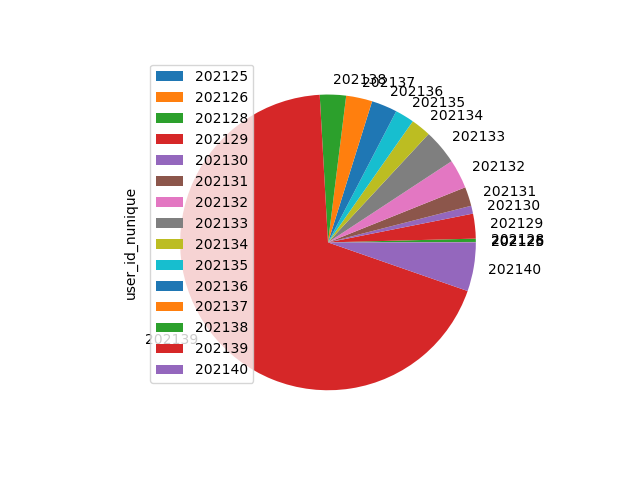

In [9]:
# visualize users
users.sort_values(by='time_aggregation', ascending=True).head(60).plot(kind='pie', subplots=True)
plt.show()

## Sessions

In [10]:
# calculate unique sessions
sessions = timeframe_df.groupby('time_aggregation').aggregate({'session_id':'nunique'})

sessions.sort_values(by='time_aggregation', ascending=False).head()

,session_id_nunique
time_aggregation,
202140,259
202139,2911
202138,180
202137,157
202136,161


/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


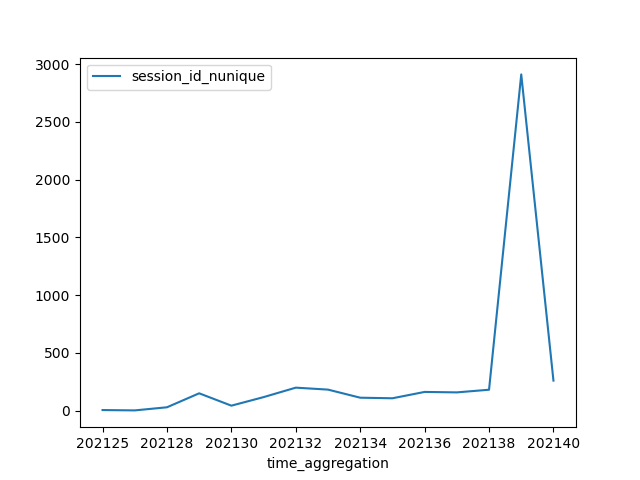

In [44]:
# visualize sessions
sessions.sort_values('time_aggregation', ascending=True).head(60).plot()
plt.show()

## Sessions per user

In [12]:
# merge users and sessions
users_sessions = sessions.merge(users, how='inner', on='time_aggregation')

# calculate average sessions per user
users_sessions['sessions_per_user_avg'] = users_sessions['session_id_nunique'] / users_sessions['user_id_nunique']

# clean-up columns
del(users_sessions['session_id_nunique'])
del(users_sessions['user_id_nunique'])

users_sessions.sort_values('time_aggregation', ascending=False).head()

,sessions_per_user_avg
time_aggregation,
202140,1.166667
202139,1.016766
202138,1.512605
202137,1.319328
202136,1.376068


/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


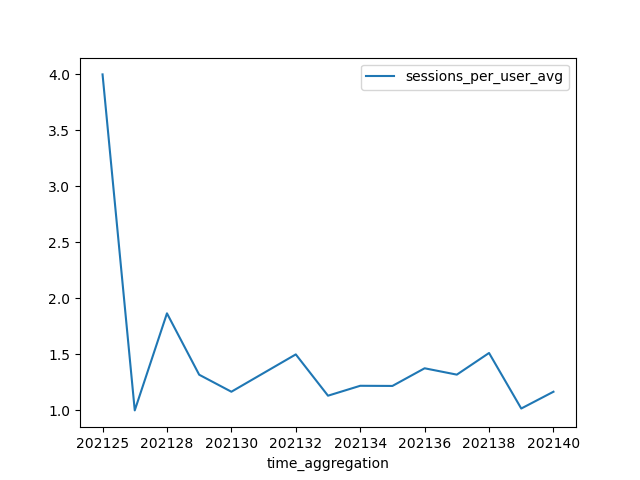

In [43]:
# visualize average sessions per user
users_sessions.sort_values(by='time_aggregation', ascending=True).head(60).plot()
plt.show()

## New users

In [14]:
# define first seen per user, based on full dataset
user_first_seen = full_df.groupby('user_id').aggregate({'time_aggregation':'min'})

# calculate new users for each timeframe
new_users = user_first_seen.groupby('time_aggregation_min').aggregate({'user_id':'nunique'})

# merge with total users, to calculate ratio and limit to timerange
new_total_users = users.merge(new_users, how='inner', left_on='time_aggregation', right_on='time_aggregation_min', suffixes=('_total', '_new'))

# NOTE: also would be good to delete the index column time_aggregation_min, but we have no function for this yet

# calculate new & returning user share
new_total_users['new_user_share'] = new_total_users['user_id_nunique_new'] / new_total_users['user_id_nunique_total']
new_total_users['returning_user_share'] = (new_total_users['user_id_nunique_total'] - new_total_users['user_id_nunique_new']) / new_total_users['user_id_nunique_total']

new_total_users.sort_values(by='time_aggregation', ascending=False).head()

,,user_id_nunique_total,user_id_nunique_new,new_user_share,returning_user_share
time_aggregation,time_aggregation_min,,,,
202140,202140,222,208,0.936937,0.063063
202139,202139,2863,2845,0.993713,0.006287
202138,202138,119,109,0.915966,0.084034
202137,202137,119,103,0.865546,0.134454
202136,202136,117,104,0.888889,0.111111


/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


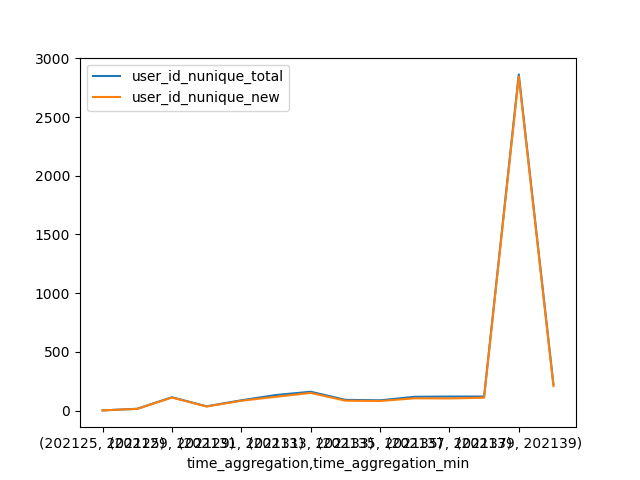

In [37]:
# visualize new users
new_total_users[['user_id_nunique_new', 'user_id_nunique_total']].sort_values(by='time_aggregation', ascending=True).head(60).plot()
plt.show()

# NOTE: also would be good to delete the index column time_aggregation_min, but we have no function for this yet, not the x-axis is showing twice

/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


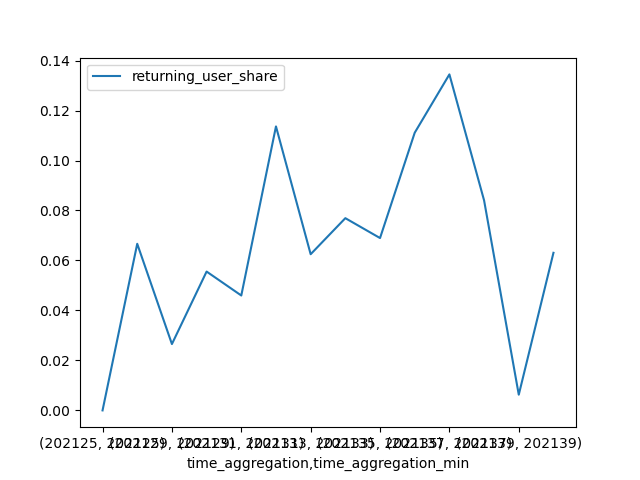

In [36]:
# visualize returning users
new_total_users[['returning_user_share']].sort_values(by='time_aggregation', ascending=True).head(60).plot()
plt.show()

## Frequency

In [17]:
# calculate total users
# NOTE; this is not possible in pandas, and therefore not super intuitive. timeframe_df['user_id'].nunique() should be working, on the list
total_users = timeframe_df.groupby()['user_id'].nunique()

# number of total sessions per user
total_sessions_user = timeframe_df.groupby(['user_id']).aggregate({'session_id':'nunique'})

# calculate frequency
frequency = total_sessions_user.groupby(['session_id_nunique']).aggregate({'user_id':'nunique'})

# add total users and calculate share per number of sessions
frequency['share_of_users'] = frequency['user_id_nunique'] / total_users['user_id_nunique'][1]

frequency.sort_values(by='session_id_nunique', ascending=True).head()

,user_id_nunique,share_of_users
session_id_nunique,,
1,3920,0.969577
2,80,0.019787
3,16,0.003957
4,7,0.001731
5,4,0.000989


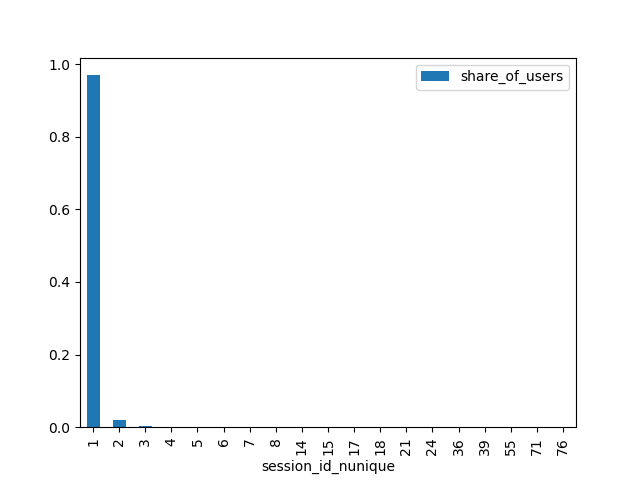

In [42]:
# visualize frequency
frequency[['share_of_users']].sort_values(by='session_id_nunique', ascending=True).head(60).plot(kind='bar')
plt.show()

## Events

In [19]:
# number of total user and hits per feature
users_per_event = timeframe_df.groupby(['time_aggregation', 'feature']).aggregate({'user_id':'nunique','session_hit_number':'count'})

users_per_event.sort_values(by=['time_aggregation', 'user_id_nunique'], ascending=False).head()

# TODO: 
# 1) add feature aggregation magic here, so we make the features show-off what we can do much more 
# 2) add location stack, showing the power of this very soon in the demo's

user_id_nunique  \
time_aggregation feature                                                               
202140           (WebDocumentContext,#document)                                  178   
                 (WebDocumentContext,#document),(SectionContext,...               60   
                 (WebDocumentContext,#document),(SectionContext,...               50   
                 (WebDocumentContext,#document),(NavigationConte...               45   
                 (WebDocumentContext,#document),(SectionContext,...               44   

                                                                     session_hit_number_count  
time_aggregation feature                                                                       
202140           (WebDocumentContext,#document)                                           300  
                 (WebDocumentContext,#document),(SectionContext,...                       105  
                 (WebDocumentContext,#document),(SectionContext,...                       105  
                 (WebDocumentContext,#document),(NavigationConte...                        75  
                 (WebDocumentContext,#document),(SectionContext,...                        75

## Conversion

In [20]:
# TODO: 
# We can do much better here once we integrate feature selection & aggregation

# NOTE: WE NEED TO UPDATE THIS ONCE THE FIRST NEW EVENT FORMAT DATA COMES IN FOR A CONVERSION
# set the goal event that you define as conversion, using our subcribe-to-mailing
conv_selector = (timeframe_df['feature'] == '(WebDocumentContext,#document),(InputContext,keep-me-posted-input),(ButtonContext,subscribe)')

# create df with only conversion events
conversions_df = timeframe_df[conv_selector]

# calculate conversions, now per user, but can easily be aggregated to session_id instead
conversions = conversions_df.groupby('time_aggregation').aggregate({'user_id':'nunique'})

# merge with users, but can easily be done with sessions instead
conversion_rate = conversions.merge(users, how='inner', on='time_aggregation', suffixes=('_converting', '_total'))

# calculate conversion rate
conversion_rate['conversion_rate'] = conversion_rate['user_id_nunique_converting'] / conversion_rate['user_id_nunique_total']

conversion_rate.sort_values(by='time_aggregation', ascending=False).head()

,user_id_nunique_converting,user_id_nunique_total,conversion_rate
time_aggregation,,,
202139,1,2863,0.000349
202138,4,119,0.033613
202137,1,119,0.008403
202136,5,117,0.042735
202135,4,87,0.045977


/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


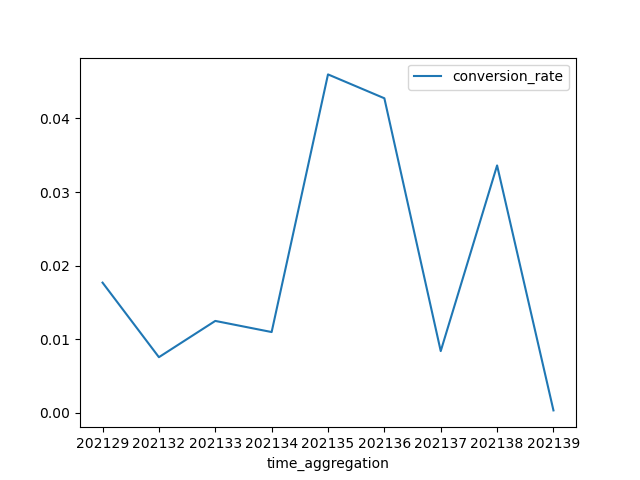

In [38]:
# visualize conversion rate
conversion_rate[['conversion_rate']].sort_values(by='time_aggregation', ascending=True).head(60).plot()
plt.show()

## Bounce rate

In [22]:
# NOTE: we need to limit this to page or screen views, instead of all events. Do this once we have integration feature selection.

# gather sessions, hits per timeframe
hits_sessions = timeframe_df[['time_aggregation', 'session_id', 'session_hit_number']]

# calculate hits per session
hits_per_session = hits_sessions.groupby(['time_aggregation', 'session_id']).aggregate({'session_hit_number':'nunique'})

# select sessions with only one hit
hit_selector = (hits_per_session['session_hit_number_nunique'] == 1)
single_hit_sessions = hits_per_session[hit_selector].to_frame()

# count these single hit sessions per timeframe
bounced_sessions = single_hit_sessions.groupby('time_aggregation').aggregate({'session_id':'nunique'})

# merge with total sessions
bounce_rate = bounced_sessions.merge(sessions, how='inner', on='time_aggregation', suffixes=('_bounce', '_total'))

# calculate bounce rate
bounce_rate['bounce_rate'] = bounce_rate['session_id_nunique_bounce'] / bounce_rate['session_id_nunique_total']

bounce_rate.sort_values(by='time_aggregation', ascending=False).head()

,session_id_nunique_bounce,session_id_nunique_total,bounce_rate
time_aggregation,,,
202140,131,259,0.505792
202139,164,2911,0.056338
202138,131,180,0.727778
202137,107,157,0.681529
202136,108,161,0.670807


/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


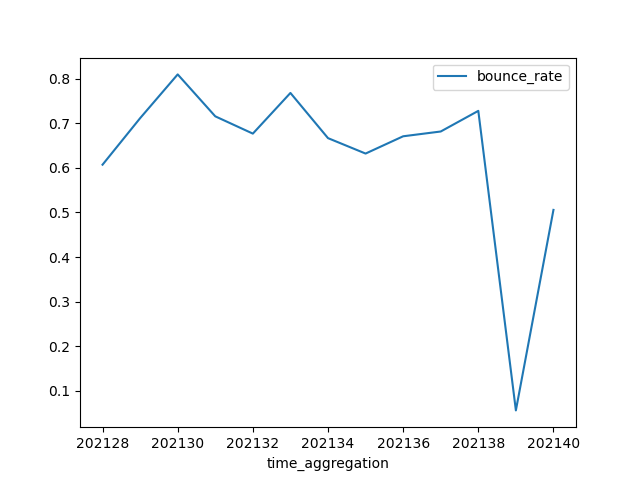

In [39]:
# visualize bounce rate
bounce_rate[['bounce_rate']].sort_values(by='time_aggregation', ascending=True).head(60).plot()
plt.show()

## Session duration

In [24]:
# calculate duration of each session
# NOTE: we want this to work, but that is a bug, on the list:
# session_duration = timeframe_df.groupby(['session_id']).aggregate({'moment':['min','max'],'time_aggregation':'min'})

session_duration = timeframe_df.groupby(['session_id']).aggregate(['moment', 'moment', 'time_aggregation'], ['min', 'max', 'min'])

session_duration['session_duration'] = session_duration['moment_max'] - session_duration['moment_min']

# check which sessions have duration of zero
# NOTE: not very intuitive. on the list to improve
session_duration['session_duration_zero'] = session_duration['session_duration'] == '0'

# calculate average session duration
avg_session_duration = session_duration.groupby(['time_aggregation_min', 'session_duration_zero']).aggregate(['session_duration', 'session_id'],['average', 'count'])

# merge with total sessions and calculate share
duration_breakdown = avg_session_duration.merge(sessions, how='inner', left_on='time_aggregation_min', right_on='time_aggregation')

# clean-up and rename columns
duration_breakdown['share_of_sessions'] = duration_breakdown['session_id_count'] / duration_breakdown['session_id_nunique']
del(duration_breakdown['session_id_nunique'])

duration_breakdown.sort_values(by='time_aggregation_min', ascending=False).head(6)

# NOTE: also would be good to delete the index column time_aggregation, but we have no function for this yet

<class 'AttributeError'>: 'BuhTuhSeriesUuid' object has no attribute 'moment'

## Session duration between events

In [25]:
# define the start and stop events to measure the duration in between
start_event = '(WebDocumentContext,#document)'
stop_event = '(WebDocumentContext,#document),(SectionContext,footer)'

# filter on only these events
start_stop = timeframe_df[(timeframe_df.feature == start_event) | (timeframe_df.feature == stop_event)]

# get previous (because of the sorting) event for stop event _in the same session, window_lag(n) returns the nth previous value in the partition
window = start_stop.sort_values('moment').window('session_id')
start_stop['prev_event'] = start_stop.feature.window_lag(window)
start_stop['prev_moment'] = start_stop.moment.window_lag(window)

# create a copy of this df with as base_node the current df's state
# note: this is a temp fix until we automatically create a new node
start_stop = start_stop.get_df_materialized_model()

# filter: for each stop event, select the closest preceeding start event
complete = start_stop[(start_stop.feature == stop_event) & (start_stop.prev_event == start_event)]

# calculate duration
complete['duration'] = complete.moment - complete.prev_moment

# calculate average duration per timeframe
duration_between_events = complete.groupby('time_aggregation').aggregate({'duration':'average'})

duration_between_events.sort_values(by='time_aggregation', ascending=False).head()

,duration_average
time_aggregation,
202140,00:00:00.197491
202139,00:00:00.177333


## Retention

In [26]:
# select all active moments for each user
user_moments = timeframe_df.groupby(['user_id', 'time_aggregation']).aggregate({'moment':'count'})

# merge with first seen df
user_activity = user_moments.merge(user_first_seen, how='inner', on='user_id')

# clean-up and rename columns
user_activity['new_user_cohort'] = user_activity['time_aggregation_min']
del(user_activity['time_aggregation_min'])
del(user_activity['moment_count'])  

# for each new_user_cohort count how many users get back per timeframe
retention_input = user_activity.groupby(['new_user_cohort', 'time_aggregation']).aggregate({'user_id':'nunique'})

# add the size of each new user cohort
cohorts = retention_input.merge(new_users, how='inner', left_on='new_user_cohort', right_on='time_aggregation_min', suffixes=('_active', '_cohort'))

# NOTE: after we can rename/delete an index, remove the time_aggregation_min column here, it's duplicate

# calculate classic retention (so not rolling retention, where users are required to be active each timeframe)
cohorts['retention'] = cohorts['user_id_nunique_active'] / cohorts['user_id_nunique_cohort']

# now switch to Pandas, as the dataset is small enough
cohorts_df = cohorts.to_df().reset_index()

# create typical retention matrix
cohorts_df = cohorts_df.astype({'new_user_cohort': 'int', 'time_aggregation': 'int'})
cohorts_df['active_in_timeframe'] = cohorts_df.time_aggregation - cohorts_df.new_user_cohort
cohorts_df.pivot('new_user_cohort', 'active_in_timeframe', 'retention')

active_in_timeframe,0,1,2,3,4,5,6,7,8,9,10,11,12,14,15
new_user_cohort,,,,,,,,,,,,,,,
202125,1.0,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,NaN,1.0,1.0
202128,1.0,0.142857,NaN,0.071429,0.214286,0.142857,0.142857,NaN,0.214286,0.214286,0.071429,0.142857,0.142857,NaN,NaN
202129,1.0,0.009091,0.018182,0.045455,0.027273,0.018182,0.018182,0.027273,0.018182,0.009091,0.027273,0.027273,NaN,NaN,NaN
202130,1.0,NaN,0.029412,NaN,NaN,NaN,NaN,0.029412,0.029412,0.029412,NaN,NaN,NaN,NaN,NaN
202131,1.0,0.060241,0.024096,0.024096,NaN,0.024096,0.036145,0.024096,0.024096,0.012048,NaN,NaN,NaN,NaN,NaN
202132,1.0,0.017094,0.008547,0.008547,0.008547,0.008547,0.008547,0.008547,0.008547,NaN,NaN,NaN,NaN,NaN,NaN
202133,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202134,1.0,0.035714,0.011905,0.023810,0.011905,0.023810,0.011905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202135,1.0,0.024691,0.024691,0.012346,0.012346,0.012346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## User timeline

In [27]:
# show the timeline of an indivual user's events
# NOTE: we can make this better with feature selection & aggregation

# select the spefic user we want to replay
# NOTE: .astype('string') is more something buhtuh should handle, on list
user_selector = (timeframe_df['user_id'].astype('string') == '320db8ee-847c-424b-8291-c65d021575aa')

# create df with only this user's events
selected_user_df = timeframe_df[user_selector]

# NOTE: we can apply feature selection and maybe sankey visual here
# timeline of this user's events
user_timeline = selected_user_df[['moment','feature']]

user_timeline.sort_values(by='moment', ascending=True).head(30)

,moment,feature
event_id,,
24a707ef-3861-4aa8-8ecd-c2eb61c32a02,2021-08-10 10:01:55.167,"(WebDocumentContext,#document)"
83888cd7-cf87-4214-b702-b98f932ca2d5,2021-08-10 10:02:02.668,"(WebDocumentContext,#document),(SectionContext..."
34250965-6214-4902-a2fc-c29a82d643be,2021-08-10 10:02:05.332,"(WebDocumentContext,#document)"
a0de0aa8-a4d8-4b81-9f9d-d08f613cfcfe,2021-08-10 10:02:24.402,"(WebDocumentContext,#document),(SectionContext..."
4774b0d9-c6dc-4194-a45a-e25709aabdbe,2021-08-10 10:02:32.395,"(WebDocumentContext,#document),(SectionContext..."
aab8d4a1-f1ba-4841-9f32-42d1b44a5238,2021-08-10 10:02:36.710,"(WebDocumentContext,#document)"
4a369d1a-c5e2-4b9e-8e0f-1e54ab9e30f2,2021-08-12 06:54:26.046,"(WebDocumentContext,#document)"
48a2d7ba-60e1-4712-8b2d-5be89e23523b,2021-08-12 13:29:54.758,"(WebDocumentContext,#document)"
edf0ecff-b5a2-4b67-90be-8ddda98d5dcc,2021-08-13 09:21:22.966,"(WebDocumentContext,#document)"


# TODO

## WIP Recency

In [28]:
# select all active days for each user
user_days = timeframe_df.groupby(['user_id', 'day'])['session_id'].nunique()

user_days['day_copy'] = user_days.index['day']

# get previous (because of the sorting) day for each user
# window = user_days.sort_values('day').window('user_id')
# user_days['prev_day'] = user_days.day.window_lag(window)

#user_days.head()
# create a copy of this df with as base_node the current df's state
# note: this is a temp fix until we automatically create a new node
#start_stop = start_stop.get_df_materialized_model()

<class 'ValueError'>: Index of assigned value does not match index of DataFrame. Value: None, df: {'user_id': <buhtuh.series.series_uuid.BuhTuhSeriesUuid object at 0x354cc68>, 'day': <buhtuh.series.series_datetime.BuhTuhSeriesDate object at 0x4fb5638>}

In [29]:
# below parts first require some next steps in dub_buh_tuh

## WIP Stack

In [30]:
# timeframe_df.global_contexts.json.get_value('ApplicationContext').head()

timeframe_df.global_contexts.json[0].head()

event_id
77cabbef-f969-4a83-85c9-970d57026a0f    {'id': 'device', '_type': 'DeviceContext', '_t...
27fd2380-54d0-493d-8a4a-cde7ef424ded    {'id': 'device', '_type': 'DeviceContext', '_t...
62010d72-c77a-4199-ac46-bd702eb4c14d    {'id': 'device', '_type': 'DeviceContext', '_t...
cba29942-ad58-4dcd-9273-a7c2b743d6cf    {'id': 'device', '_type': 'DeviceContext', '_t...
d703e364-60ac-4feb-81b6-ae62f12ed82e    {'id': 'device', '_type': 'DeviceContext', '_t...
Name: global_contexts, dtype: object

## Conversion funnel

In [31]:
# TODO
# Self-merge is giving not the ouput we expect. 
# Without that, we can not create a sankey that looks like a familiar funnel. 
# See example here https://gitlab.com/newrelity/objectiv-taxonomy-prototypes/-/blob/web-analytics/data-science/issue_example_self_merge.ipynb

# showing the sequence of events for converting users

# resuse the df with only conversion events, select the users and their conversion moment
converting_users = conversions_df['user_id', 'moment']

# for now, we focus on the first conversion event. Later it is nice to also make it possible to see events between first and 2nd conversion, and so on.
converting_users = converting_users.groupby(['user_id'])['moment'].min()
converting_users['first_conversion_moment'] = converting_users['moment_min']
del(converting_users['moment_min'])

# merge with the df that has all user events in the timeframe
converting_users_events = timeframe_df.merge(converting_users, [('user_id', 'user_id')])

# select all events that converting users had up to their first conversion moment
event_selector = (converting_users_events['moment'] <= converting_users_events['first_conversion_moment'])
pre_conversion_events = converting_users_events[event_selector]

# create pairs of from-to events based on session hit number
event_sequence = pre_conversion_events['session_id', 'session_hit_number', 'feature']

event_pairs = event_sequence.merge(event_sequence, [('session_id')])

event_pairs.head(50)


<class 'NotImplementedError'>: Only str, (set|list)[str], slice or BuhTuhSeriesBoolean are supported, but got <class 'tuple'>

In [32]:
df_sank = pd.read_csv('buh.csv')

<class 'NameError'>: name 'pd' is not defined

In [33]:
categories = set(df_sank['source']).union(set(df_sank['target']))
df_sank['source'] = pd.Categorical(df_sank['source'], categories=categories)
df_sank['target'] = pd.Categorical(df_sank['target'], categories=categories)

text_in_title = str('title')
node = dict(
      pad=15,
      thickness=20,
      line=dict(color="black", width=0.5),
      label=df_sank.source.cat.categories,
      color='blue'
    )
link = pd.concat([df_sank[['source', 'target']].apply(lambda x: x.cat.codes), df_sank['value']], axis=1).to_dict('list')
fig = go.Figure(go.Sankey(arrangement="fixed", link=link, node=node), {'clickmode': 'event+select'})
fig.update_layout(title_text=text_in_title, font_size=10)

<class 'NameError'>: name 'df_sank' is not defined

## Events flow

In [34]:
# events per session hit number
events_per_hit_number = timeframe_df[selector].groupby(['session_hit_number', 'feature'])['session_id'].nunique()

events_per_hit_number.sort_values({'session_hit_number':True}).head()

<class 'ValueError'>: Cannot apply Boolean series with a different base_node to DataFrame.Hint: make sure the Boolean series is derived from this DataFrame. Alternative: use df.merge(series) to merge the series with the df first,and then create a new Boolean series on the resulting merged data.

## Traffic source

In [35]:
# TODO
# For Traffic Source, Geo and Device metrics, we would need to get source/geo/device data from GlobalContext in a easy way.
# We can then also blend it in all metrics above as slicing option.

## Geo 

## Devices